# Подготовка

In [1]:
%pip install -U pip setuptools
%pip install scikit-learn pandas matplotlib tqdm pydot-ng graphviz numba torch scipy==1.10
%pip install tensorflow keras==2.15
%pip install sentence-transformers gensim simple_elmo

# Without GPU  
# %pip install spacy

# GPU
%pip install spacy[cuda12x]
%pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.4.* dask-cudf-cu12==24.4.* cuml-cu12==24.4.* \
    cugraph-cu12==24.4.* cuspatial-cu12==24.4.* cuproj-cu12==24.4.* \
    cuxfilter-cu12==24.4.* cucim-cu12==24.4.* pylibraft-cu12==24.4.* \
    raft-dask-cu12==24.4.* cuvs-cu12==24.4.*
%load_ext cudf.pandas
!nvidia-smi

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Fri May 17 18:32:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.65                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |

In [2]:
!spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 8.3 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
import warnings
warnings.filterwarnings('ignore')

# общее
from collections import Counter
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from tqdm import tqdm
import numba

# анализ текста
import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_lg")

# векторайзеры
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from numpy.linalg import norm
import gensim
from gensim import downloader
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sentence_transformers import SentenceTransformer, util
import simple_elmo
from simple_elmo import ElmoModel
word2vec_pretrained = gensim.downloader.load('word2vec-google-news-300')

# нейронная сеть
import tensorflow
import torch
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

import gc
gc.collect()

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

2024-05-17 18:33:56.628336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 18:33:56.740692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 18:33:56.740754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 18:33:56.746251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 18:33:56.790702: I tensorflow/core/platform/cpu_feature_guar

# Загрузка датасета

In [4]:
df_books = pd.read_json("data/books.json", lines=True)[:100000]
df_queries = pd.read_json("data/queries.json", lines=True)
display(df_books)
display(df_queries)

,book_id,title,publication_year,language_code,format,description,url
0,287141,The Aeneid for Boys and Girls,2006,,Paperback,"Relates in vigorous prose the tale of Aeneas, ...",https://www.goodreads.com/book/show/287141.The...
1,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,2009,,Paperback,"To Kara's astonishment, she discovers that a p...",https://www.goodreads.com/book/show/6066812-al...
2,89378,Dog Heaven,1995,eng,Hardcover,In Newbery Medalist Cynthia Rylant's classic b...,https://www.goodreads.com/book/show/89378.Dog_...
3,3209312,"Moths and Mothers, Feathers and Fathers: A Sto...",,,,,https://www.goodreads.com/book/show/3209312-mo...
4,1698376,What Do You Do?,2005,,Board Book,WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,https://www.goodreads.com/book/show/1698376.Wh...
...,...,...,...,...,...,...,...
99995,15777861,Change the World Before Bedtime,2012,eng,Paperback,"Written in simple, engaging rhyme, this story ...",https://www.goodreads.com/book/show/15777861-c...
99996,25982824,Click!,2016,,Hardcover,Things are not at all what they seem in this p...,https://www.goodreads.com/book/show/25982824-c...
99997,1098418,The Daddy Machine,2004,,Paperback,Two children who have two mothers dream of wha...,https://www.goodreads.com/book/show/1098418.Th...
99998,22570469,The Adventures of Buster Bear,2008,eng,Audiobook,The Adventures of Buster Bear is another set o...,https://www.goodreads.com/book/show/22570469-t...


,book_id,query
0,22718719,"Memory is really foggy,but still, the book was..."
1,15276080,Spoiler: One member of the group drops out of ...
2,9342256,I read this book somewhere between 2020 and 20...
3,26238686,Spoilers here.The character follows the entity...
4,6596581,I read this book a long time ago when I was in...
...,...,...
984,273730,"I associate the word ""dreary"" with this book- ..."
985,29208332,I read a book in middle school (2004-2007) tha...
986,1422913,I'm looking for a Christmas picture book I rea...
987,35858102,it said title was too long so: A huge differen...


In [5]:
def clear(doc):
    cleared = [token.lemma_ for token in doc if (token.is_stop == False and token.is_punct == False and token.is_alpha == True)]
    return " ".join(cleared)

In [6]:
df_books_tmp = pd.DataFrame([(doc, len(doc), clear(doc)) for doc in nlp.pipe(df_books["description"])], columns=["doc", "tokens_count", "clean_description"])
df_books['doc'] = df_books_tmp['doc'].values
df_books['tokens_count'] = df_books_tmp['tokens_count'].values
df_books['clean_description'] = df_books_tmp['clean_description'].values
df_books
del df_books_tmp

In [7]:
df_queries_tmp = pd.DataFrame([(doc, len(doc), clear(doc)) for doc in nlp.pipe(df_queries["query"])], columns=["doc", "tokens_count", "clean_query"])
df_queries['doc'] = df_queries_tmp['doc'].values
df_queries['tokens_count'] = df_queries_tmp['tokens_count'].values
df_queries['clean_query'] = df_queries_tmp['clean_query'].values
df_queries
del df_queries_tmp

# Анализ данных

In [8]:
# PART OF SPEECH
all_tokens_count = 0
poses_books = {}
deps_books = {}
for doc in df_books["doc"]:
    all_tokens_count += len(doc)
    poses_books = Counter(poses_books) + Counter([token.pos_ for token in doc])
    deps_books = Counter(deps_books) + Counter([token.dep_ for token in doc])

poses_books = {k: (v / all_tokens_count * 100) for k, v in sorted(poses_books.items(), key=lambda item: item[1], reverse=True)}
deps_books = {k: (v / all_tokens_count * 100) for k, v in sorted(deps_books.items(), key=lambda item: item[1], reverse=True)}

# DEPENDENCIES
all_tokens_count = 0
poses_queries = {}
deps_queries = {}
for doc in df_queries['doc']:
    all_tokens_count += len(doc)
    poses_queries = Counter(poses_queries) + Counter([token.pos_ for token in doc])
    deps_queries = Counter(deps_queries) + Counter([token.dep_ for token in doc])

poses_queries = {k: (v / all_tokens_count * 100) for k, v in sorted(poses_queries.items(), key=lambda item: item[1], reverse=True)}
deps_queries = {k: (v / all_tokens_count * 100) for k, v in sorted(deps_queries.items(), key=lambda item: item[1], reverse=True)}


,описания,запросы
NOUN,18.132178,17.642196
PUNCT,12.783205,9.263515
VERB,10.033659,12.437770
PROPN,9.221799,1.719571
ADP,9.162289,9.400655
DET,8.634392,10.404469
ADJ,7.558887,5.701010
PRON,6.383573,12.238636
AUX,4.125863,6.235793
CCONJ,3.873964,4.149889


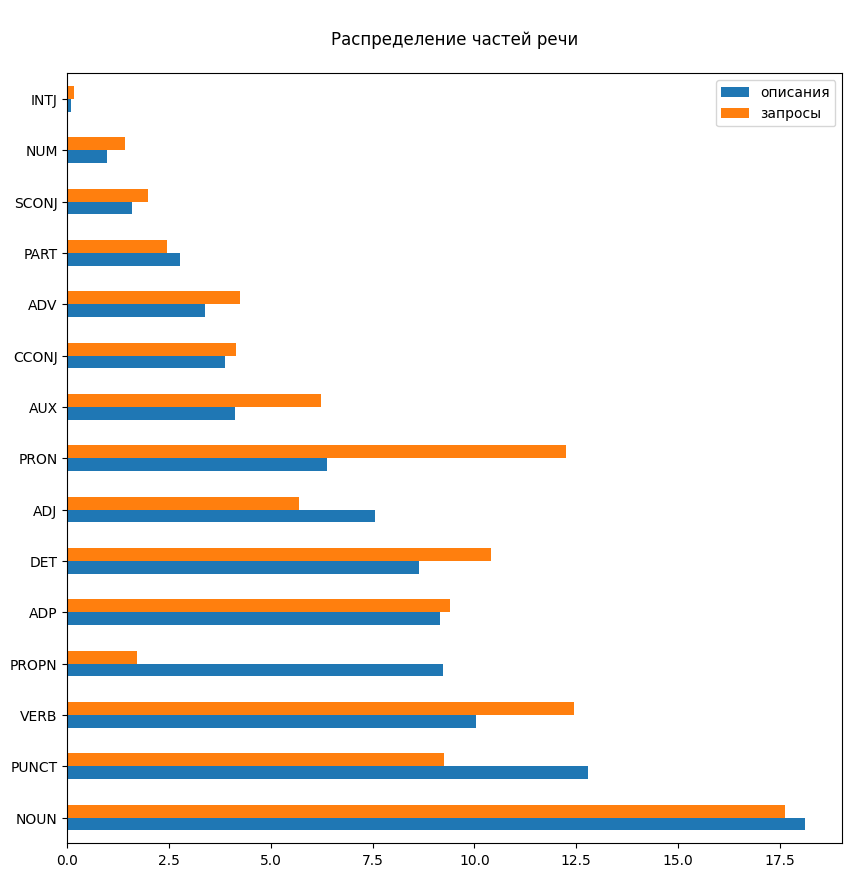

In [9]:
df_poses = pd.DataFrame.from_dict([poses_books, poses_queries]).transpose()
df_poses.columns = ["описания", "запросы"]
df_poses = df_poses.drop(index=['X', 'SYM', 'SPACE'])
df_poses.plot.barh(title="\nРаспределение частей речи\n", figsize=(10,10))
df_poses

,описания,запросы
acl,0.481444,0.401400
advcl,1.526458,1.473471
advmod,3.974433,4.804278
amod,6.507751,4.087895
appos,1.148679,0.454628
cc,3.879729,4.116700
conj,4.173768,4.034041
dep,1.204483,0.143402
nmod,0.420580,0.288056


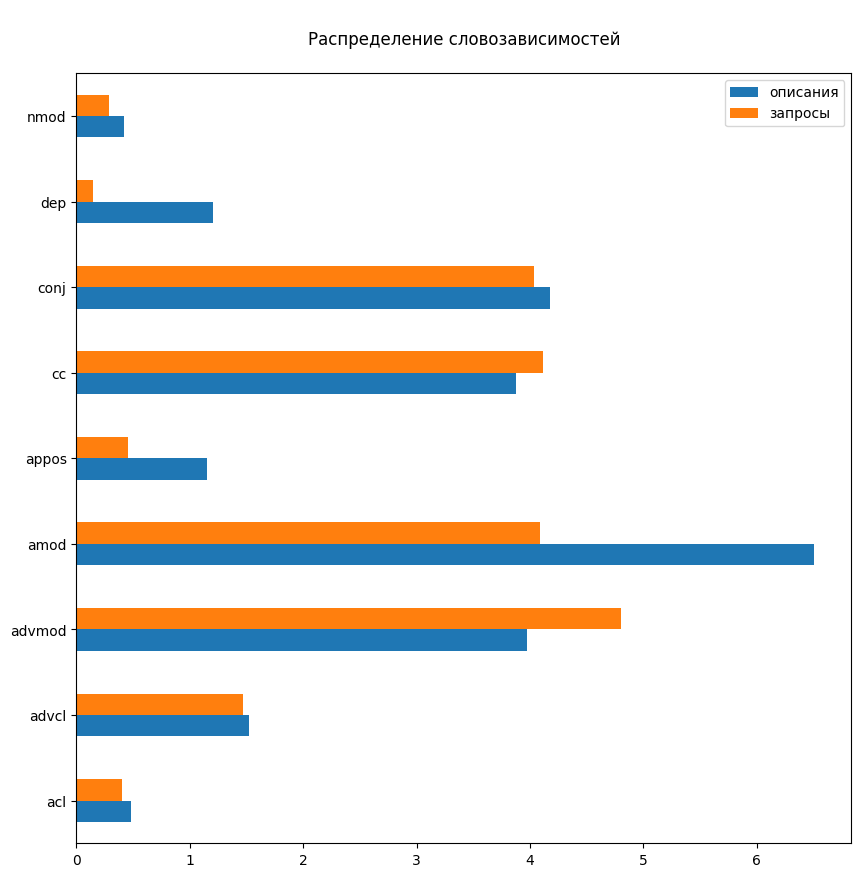

In [10]:
df_deps = pd.DataFrame.from_dict([deps_books, deps_queries])
df_deps = df_deps[["acl", "advcl", "advmod", "amod", "appos", "cc", "conj", "dep", "nmod"]].transpose()
df_deps.columns = ["описания", "запросы"]
df_deps.plot.barh(title="\nРаспределение словозависимостей\n", figsize=(10,10))
df_deps

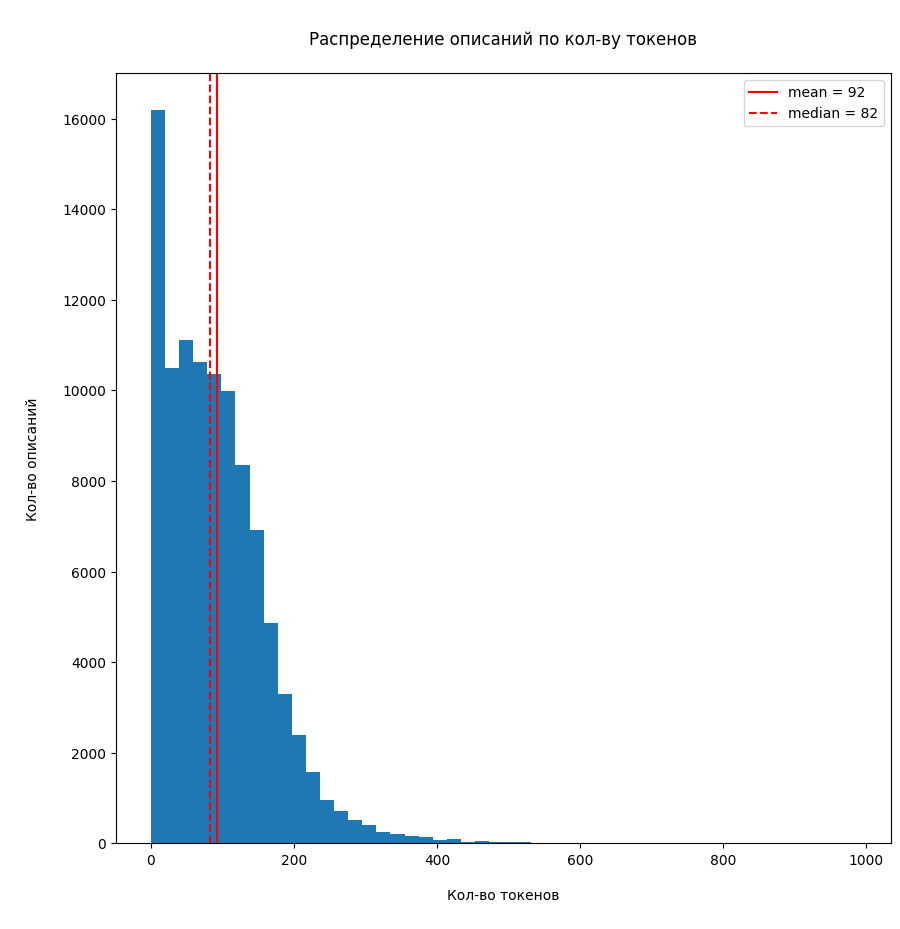

In [11]:
books_tokens_count = df_books[df_books['tokens_count'] < 1000]['tokens_count']
books_tokens_count.plot.hist(title="\nРаспределение описаний по кол-ву токенов\n", figsize=(10,10), bins=50)
plt.axvline(x=books_tokens_count.mean(), color='r', linestyle='-')
plt.axvline(x=books_tokens_count.median(), color='r', linestyle='--')
plt.ylabel('\nКол-во описаний\n')
plt.xlabel('\nКол-во токенов\n')
plt.legend(handles=[plt.Line2D([0], [0], linestyle='-', color='r', label=f'mean = {int(books_tokens_count.mean())}'),
                    plt.Line2D([0], [0], linestyle='--', color='r', label=f'median = {int(books_tokens_count.median())}')],
                    loc="upper right")

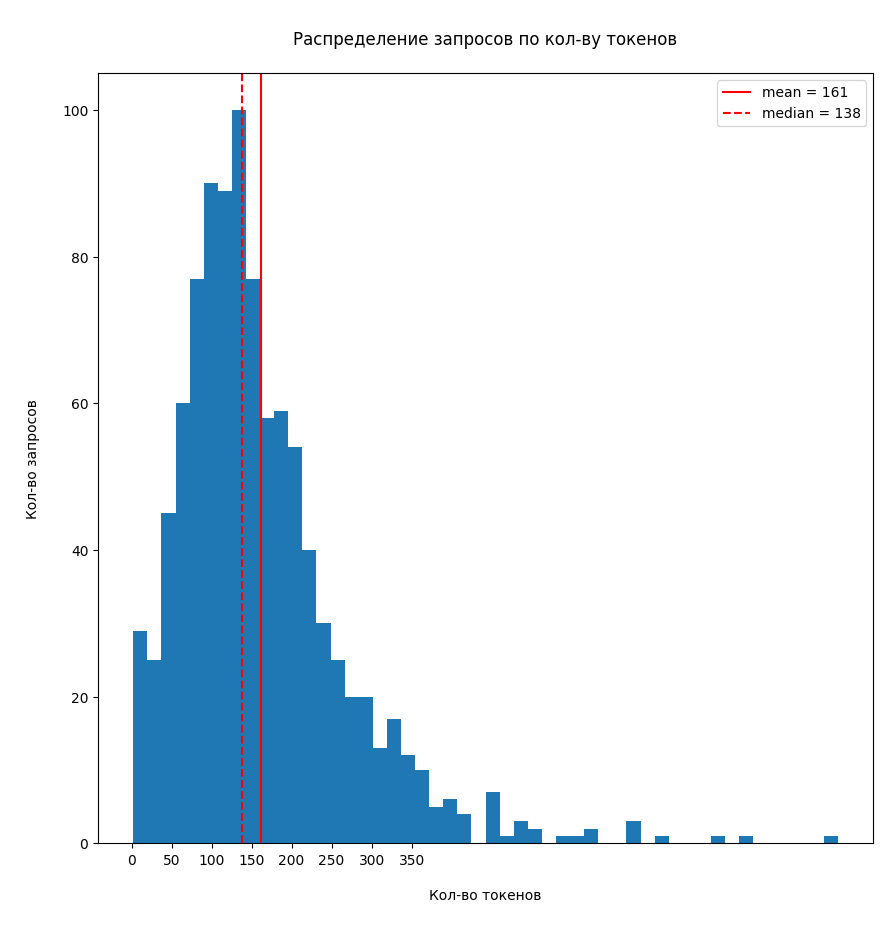

In [12]:
df_queries['tokens_count'].plot.hist(title="\nРаспределение запросов по кол-ву токенов\n", figsize=(10,10), bins=50)
plt.axvline(x=df_queries['tokens_count'].mean(), color='r', linestyle='-')
plt.axvline(x=df_queries['tokens_count'].median(), color='r', linestyle='--')
plt.xticks(range(0, 400, 50))
plt.ylabel('\nКол-во запросов\n')
plt.xlabel('\nКол-во токенов\n')
plt.legend(handles=[plt.Line2D([0], [0], linestyle='-', color='r', label=f"mean = {int(df_queries['tokens_count'].mean())}"),
                    plt.Line2D([0], [0], linestyle='--', color='r', label=f"median = {int(df_queries['tokens_count'].median())}")],
                    loc="upper right")

# Очистка датасета

In [13]:
df_books = df_books.dropna()
df_books = df_books[df_books.apply(lambda x: 10 < x['tokens_count'] < 400, axis=1)].reset_index(drop=True)

df_queries = df_queries.dropna()
df_queries = df_queries[df_queries.apply(lambda x: 10 < x['tokens_count'] < 400, axis=1)].reset_index(drop=True)
df_queries = df_queries[df_queries.apply(lambda x: x['book_id'] in list(df_books['book_id']), axis=1)].reset_index(drop=True)

display(df_books)
display(df_queries)

,book_id,title,publication_year,language_code,format,description,url,doc,tokens_count,clean_description
0,287141,The Aeneid for Boys and Girls,2006,,Paperback,"Relates in vigorous prose the tale of Aeneas, ...",https://www.goodreads.com/book/show/287141.The...,"(Relates, in, vigorous, prose, the, tale, of, ...",61,relate vigorous prose tale Aeneas legendary an...
1,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,2009,,Paperback,"To Kara's astonishment, she discovers that a p...",https://www.goodreads.com/book/show/6066812-al...,"(To, Kara, 's, astonishment, ,, she, discovers...",191,Kara astonishment discover portal open bedroom...
2,89378,Dog Heaven,1995,eng,Hardcover,In Newbery Medalist Cynthia Rylant's classic b...,https://www.goodreads.com/book/show/89378.Dog_...,"(In, Newbery, Medalist, Cynthia, Rylant, 's, c...",126,Newbery Medalist Cynthia Rylant classic bestse...
3,1698376,What Do You Do?,2005,,Board Book,WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,https://www.goodreads.com/book/show/1698376.Wh...,"(WHAT, DO, YOU, DO, ?, \n, A, hen, lays, eggs,...",31,hen lay egg cow give milk elephant squirt wate...
4,2592648,It's Funny Where Ben's Train Takes Him,1999,,Hardcover,Ben draws a train that takes him to all sorts ...,https://www.goodreads.com/book/show/2592648-it...,"(Ben, draws, a, train, that, takes, him, to, a...",21,Ben draw train take sort wonderful place retur...
...,...,...,...,...,...,...,...,...,...,...
86282,6277254,The Number Garden,2009,,Hardcover,Can you count all the fun things in this perfe...,https://www.goodreads.com/book/show/6277254-th...,"(Can, you, count, all, the, fun, things, in, t...",144,count fun thing perfect partner Alphabet Room ...
86283,15777861,Change the World Before Bedtime,2012,eng,Paperback,"Written in simple, engaging rhyme, this story ...",https://www.goodreads.com/book/show/15777861-c...,"(Written, in, simple, ,, engaging, rhyme, ,, t...",97,write simple engage rhyme story take inspirati...
86284,25982824,Click!,2016,,Hardcover,Things are not at all what they seem in this p...,https://www.goodreads.com/book/show/25982824-c...,"(Things, are, not, at, all, what, they, seem, ...",93,thing picture book mystery fill rhyme wordplay...
86285,1098418,The Daddy Machine,2004,,Paperback,Two children who have two mothers dream of wha...,https://www.goodreads.com/book/show/1098418.Th...,"(Two, children, who, have, two, mothers, dream...",25,child mother dream like father pretend invent ...


,book_id,query,doc,tokens_count,clean_query
0,22718719,"Memory is really foggy,but still, the book was...","(Memory, is, really, foggy, ,, but, still, ,, ...",204,memory foggy book ya read book pretty sure wom...
1,6596581,I read this book a long time ago when I was in...,"(I, read, this, book, a, long, time, ago, when...",178,read book long time ago elementary school youn...
2,1714672,. the cover is two girls and a rose pendant. t...,"(., the, cover, is, two, girls, and, a, rose, ...",114,cover girl rose pendant girl sew blog find mom...
3,1190705,i read the book in 2009. the book had a blue c...,"(i, read, the, book, in, 2009, ., the, book, h...",49,read book book blue cover believe sailboat pos...
4,4973399,"Hi all!Some 30+ years ago, middle to late 1980...","(Hi, all!Some, 30, +, years, ago, ,, middle, t...",98,hi year ago middle late give book come finish ...
...,...,...,...,...,...
346,1415644,"I know this is really vague, but it's a childr...","(I, know, this, is, really, vague, ,, but, it,...",184,know vague child story tell year ago girl Sara...
347,16172418,cannot for the life of me remember what is it ...,"(can, not, for, the, life, of, me, remember, w...",12,life remember call
348,11286074,"I have a very vague memory about this book, bu...","(I, have, a, very, vague, memory, about, this,...",64,vague memory book know contain person make jam...
349,7931997,Here's what I remember. - The main character i...,"(Here, 's, what, I, remember, ., -, The, main,...",191,remember main character person narrator mute t...


In [14]:
pd.set_option('display.max_colwidth', 1000)
display(df_books[["description", "clean_description"]])
display(df_queries[["query", "clean_query"]])
pd.set_option('display.max_colwidth', 50)

,description,clean_description
0,"Relates in vigorous prose the tale of Aeneas, the legendary ancestor of Romulus, who escaped from the burning city of Troy and wandered the Mediterranean for years before settling in Italy. Patterned after the Iliad and the Odyssey, the Aeneid was composed as an epic poem by Virgil, to glorify the imperial city of Rome.",relate vigorous prose tale Aeneas legendary ancestor Romulus escape burn city Troy wander Mediterranean year settle Italy pattern Iliad Odyssey Aeneid compose epic poem Virgil glorify imperial city Rome
1,"To Kara's astonishment, she discovers that a portal has opened in her bedroom closet and two goblins have fallen through! They refuse to return to the fairy realms and be drafted for an impending war. In an attempt to roust the pesky creatures, Kara falls through the portal, smack into the middle of a huge war. Kara meets Queen Selinda, who appoints Kara as a Fairy Princess and assigns her an impossible task: to put an end to the war using her diplomatic skills.\nAll's Fairy In Love And War is the eighth book in Avalon: Web of Magic, a twelve-book fantasy series for middle grade readers. Through their magical journey, the teenage heroines discover who they really are . . . and run into plenty of good guys, bad guys, and cute guys. Out of print for two years, Seven Seas is pleased to return the Avalon series to print in editions targeted for today's readers, with new manga-style covers and interior illustrations.",Kara astonishment discover portal open bedroom closet goblin fall refuse return fairy realm draft impending war attempt roust pesky creature Kara fall portal smack middle huge war Kara meet Queen Selinda appoint Kara Fairy Princess assign impossible task end war diplomatic skill Fairy Love War eighth book Avalon web Magic book fantasy series middle grade reader magical journey teenage heroine discover run plenty good guy bad guy cute guy print year Seven Seas pleased return Avalon series print edition target today reader new manga style cover interior illustration
2,"In Newbery Medalist Cynthia Rylant's classic bestseller, the author comforts readers young and old who have lost a dog. Recommended highly by pet lovers around the world, Dog Heaven not only comforts but also brings a tear to anyone who is devoted to a pet. From expansive fields where dogs can run and run to delicious biscuits no dog can resist, Rylant paints a warm and affectionate picture of the ideal place God would, of course, create for man's best friend. The first picture book illustrated by the author, Dog Heaven is enhanced by Rylant's bright, bold paintings that perfectly capture an afterlife sure to bring solace to anyone who is grieving.",Newbery Medalist Cynthia Rylant classic bestseller author comfort reader young old lose dog recommend highly pet lover world Dog Heaven comfort bring tear devoted pet expansive field dog run run delicious biscuit dog resist Rylant paint warm affectionate picture ideal place God course create man good friend picture book illustrate author Dog Heaven enhance Rylant bright bold painting perfectly capture afterlife sure bring solace grieve
3,WHAT DO YOU DO?\nA hen lays eggs...\nA cow gives milk...\nAn elephant squirts water...\nBut what does a beetle do?,hen lay egg cow give milk elephant squirt water beetle
4,Ben draws a train that takes him to all sorts of wonderful places before returning him to his own bed.,Ben draw train take sort wonderful place return bed
...,...,...
86282,"Can you count all the fun things in this perfect partner to The Alphabet Room?\nFollowing the success of Child magazine award winner The Alphabet Room, Sara Pinto uses the same format but turns to numbers to present a most delightful story-within-the concept book. A resourceful pair of rabbits plant carrot seeds and celebrate in a garden that grows as the numbers add up. Twelve elements--one sun, two rabbits, three garden chairs, through twelve stars at night--all add up to 78 items an

,query,clean_query
0,"Memory is really foggy,but still, the book was YA, I read the book in 2016-2017, the author(I'm pretty sure) was a woman, English speaking at that(American I assume) the book was set in modern times.I don't remember the main girls name but she played soccer,and her friends name was (maybe) Zoe. The main girl had a love interest who went by Taz, which was short for either Tazman or Tasmanian, she met the love interest in an antique shop,The main focus of the book was not the romance though. I think the cover was of a a tree on a hill with two girls on it, and the title (MAYBE) had the words ""The book of..."". At one point in the story we follow the main girl as she watches her friend (Zoe/Zoey?) shoplift with a new group of friends she found herself. That's all I can really remember off the top of my head, please help I've so long looking for this book.",memory foggy book ya read book pretty sure woman English speak assume book set modern time remember main girl play soccer friend maybe Zoe main girl love interest go Taz short Tazman Tasmanian meet love interest antique shop main focus book romance think cover tree hill girl title maybe word book point story follow main girl watch friend Zoe Zoey shoplift new group friend find remember head help long look book
1,"I read this book a long time ago when I was in elementary school. It had to be around 2007-2010, somewhere around there. It was about a young girl who met this boy in a graveyard. I want to say the girl just moved there or something like that. I remember her being a very sad and lonely girl. She meets this boy who says his brother died and that's whose grave he visits. The thing is is that the girl can only see the boy at the graveyard and he never leaves the graveyard. At the end of the book we find out the boy that died never had a brother. So she has been talking to his ghost the whole time. I also remember a part of the book describing the bottom of her jeans getting soaked with water and mud. It was so long ago that I read this book and I'm having trouble finding the answer of google.",read book long time ago elementary school young girl meet boy graveyard want girl move like remember sad lonely girl meet boy say brother die grave visit thing girl boy graveyard leave graveyard end book find boy die brother talk ghost time remember book describe jean getting soak water mud long ago read book have trouble find answer google
2,. the cover is two girls and a rose pendant. this girl who sews and has a blog finds out her mom died and lives with grandma. there she finds mysterious gardren which allows her to time travel to 1800s queen elizabeth. later she finds out her dad was from that era. there is a scene where kids from school bully her and her friends where one of them is on a wheelchair. another scence is when she gets blemish cream from the present time to the past to queen victoria. she also meets a boy near a well. she hasa pendant with her mom in swimsuits,cover girl rose pendant girl sew blog find mom die live grandma find mysterious gardren allow time travel queen elizabeth later find dad era scene kid school bully friend wheelchair scence get blemish cream present time past queen victoria meet boy near hasa pendant mom swimsuit
3,"i read the book in 2009. the book had a blue cover, with what i believe was a sailboat on it, possible one crossing an ocean. this has been bothering me for a week and any help you can provide would be most appreciated.",read book book blue cover believe sailboat possible cross ocean bother week help provide appreciate
4,"Hi all!Some 30+ years ago, middle to late 1980ies, I was given a book I never came around to finish reading. Mostly, because I thought it was boring.A boy, whose parent are rich, maybe aristocratic, is kidnapped. First he is transported in a car or van, later he is brought on a river boat.As far I remember the setting is contemporary Britain.Maybe the book was written for children/teens â¦H

# Векторайзеры

In [15]:
TOP_K = 10

In [16]:
def simple_vector_comp(description_vector, query_vector):
    return ((description_vector @ query_vector) / (norm(description_vector) * norm(query_vector)))

In [17]:
# ПРИМЕР РАБОТЫ
# max_features - Unable to allocate 182. GiB for an array with shape (163224, 149326) and data type float64

vectorizer = TfidfVectorizer(max_features=1500)
query = 'Harry Potter'

X_all = vectorizer.fit_transform(df_books['clean_description']).toarray()
Y = vectorizer.transform([clear(nlp(query))]).toarray().reshape(len(X_all[0]), 1)
simil = []
for X, title, book_id in zip(X_all, df_books['title'], df_books['book_id']):
    simil.append((simple_vector_comp(X, Y), title, book_id))
simil.sort(reverse=True)
simil = simil[:TOP_K]
display(simil)

[(array([0.84846953]), 'Harry and Walter', 26196459),
 (array([0.77805006]), "Happy Harry's Cafe", 13531036),
 (array([0.76155343]), 'Horrible Harry Takes the Cake', 1101248),
 (array([0.72632091]), "I Don't Like Reading", 34878558),
 (array([0.72632091]), "I Don't Like Reading", 34790397),
 (array([0.72515056]), 'Harry & Hopper', 9307124),
 (array([0.72515056]), 'Harry & Hopper', 6424103),
 (array([0.72328171]), "Mr Nobody's Eyes", 1948896),
 (array([0.69449679]), "Mr Nobody's Eyes", 28598390),
 (array([0.68333471]), 'Horrible Harry and the Goog', 3826863)]

In [18]:

# Count Vectorizer
def runCountVectorizer(descriptions: np.array, queries: np.array, features=1500) -> tuple[str, np.array, np.array]:
    vectorizer = CountVectorizer(max_features=features)
    description_vectors = vectorizer.fit_transform(descriptions).toarray()
    queries_vectors = vectorizer.transform(queries).toarray()
    return (f"Count Vectorizer (f={features})", description_vectors, queries_vectors)


# TF-IDF
def runTfidfVectorizer(descriptions: np.array, queries: np.array, features=1500) -> tuple[str, np.array, np.array]:
    vectorizer = TfidfVectorizer(max_features=features)
    description_vectors = vectorizer.fit_transform(descriptions).toarray()
    queries_vectors = vectorizer.transform(queries).toarray()
    return (f"TF-IDF Vectorizer (f={features})", description_vectors, queries_vectors)


# WORD2VEC
def runWord2VecVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = Word2Vec([entry.split(" ") for entry in descriptions])
    descriptions_vectors = np.array([vectorizer.wv.get_mean_vector(entry.split(" ")) for entry in descriptions])
    queries_vectors = np.array([vectorizer.wv.get_mean_vector(entry.split(" ")) for entry in queries])
    return ("Word2Vec", descriptions_vectors, queries_vectors)


# DOC2VEC
def runDoc2VecVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = Doc2Vec([TaggedDocument(description.split(" "), [str(i)]) for i, description in enumerate(descriptions)])
    descriptions_vectors = np.array([vectorizer.infer_vector(description.split(" ")) for description in descriptions])
    queries_vectors = np.array([vectorizer.infer_vector(query.split(" ")) for query in queries])
    return ("Doc2Vec", descriptions_vectors, queries_vectors)


# WORD2VEC (Pretrained)
def runWord2VecPretrainedVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = word2vec_pretrained
    descriptions_vectors = np.array([vectorizer.get_mean_vector(entry.split(" ")) for entry in descriptions])
    queries_vectors = np.array([vectorizer.get_mean_vector(entry.split(" ")) for entry in queries])
    return ("Word2Vec (Pretrained)", descriptions_vectors, queries_vectors)


# SENTENCE TRANSFORMER (Pretrained)
def runSentenceTransformerVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:
    vectorizer = SentenceTransformer("all-MiniLM-L6-v2")
    return ("Sentence Transformer (Pretrained)", vectorizer.encode(descriptions, convert_to_numpy=True), vectorizer.encode(queries, convert_to_numpy=True))


# ELMO (Pretrained)
# http://vectors.nlpl.eu/repository ID=225
# Corpus of Historical American English Embeddings from Language Models (ELMo)
def runElmoVectorizer(descriptions: np.array, queries: np.array) -> tuple[str, np.array, np.array]:

    vectorizer = None
    graph = tensorflow.Graph()
    with graph.as_default() as elmo_graph:
        vectorizer = ElmoModel()
        vectorizer.load("./elmo")
    with elmo_graph.as_default() as current_graph:
        tf_session = tensorflow.compat.v1.Session(graph=elmo_graph)
        with tf_session.as_default() as sess:
            vectorizer.elmo_sentence_input = simple_elmo.elmo.weight_layers("input", vectorizer.sentence_embeddings_op)
            sess.run(tensorflow.compat.v1.global_variables_initializer())
                
            descriptions_vectors = vectorizer.get_elmo_vector_average([entry.split(" ") for entry in descriptions], session=tf_session)
            queries_vectors = vectorizer.get_elmo_vector_average([entry.split(" ") for entry in queries], session=tf_session)
            return ("ELMO (Pretrained)", descriptions_vectors, queries_vectors)

In [24]:
# Simple Vector Compare
df_simple_vector_compare = {}
for vectorizer in [runCountVectorizer, runTfidfVectorizer, runWord2VecVectorizer, runDoc2VecVectorizer, runWord2VecPretrainedVectorizer, runSentenceTransformerVectorizer, runElmoVectorizer]:
    name, descriptions_vectors, queries_vectors = vectorizer(df_books['clean_description'].values, df_queries['clean_query'].values)

    found = 0
    results = []
    print(f"{name}:")
    print(f"  shapes: {descriptions_vectors.shape} x {queries_vectors.shape}")

    with tqdm(total=(descriptions_vectors.shape[0]*queries_vectors.shape[0])) as pbar:
        for query_book_id, query_vector in zip(df_queries['book_id'], queries_vectors):
            results.clear()
            for description_book_id, description_vector in zip(df_books['book_id'], descriptions_vectors):
                predict = simple_vector_comp(description_vector, query_vector)
                if predict > 0.1: results.append((predict, description_book_id))
                pbar.update(1)
            results.sort(reverse=True)
            results = results[:TOP_K]

            if query_book_id in [item[1] for item in results]:
                found += 1

                
        print(f"  found: {found}\n  total: {len(queries_vectors)}\n  acc: {found/len(queries_vectors)}\n")
        df_simple_vector_compare[name] = found / len(queries_vectors) * 100

df_simple_vector_compare = pd.DataFrame(df_simple_vector_compare).transpose()

Count Vectorizer (f=1500):
  shapes: (86287, 1500) x (351, 1500)


100%|██████████| 30286737/30286737 [04:27<00:00, 113377.60it/s]


  found: 4
  total: 351
  acc: 0.011396011396011397

TF-IDF Vectorizer (f=1500):
  shapes: (86287, 1500) x (351, 1500)


100%|██████████| 30286737/30286737 [03:16<00:00, 154421.89it/s]


  found: 9
  total: 351
  acc: 0.02564102564102564



2024-05-17 21:51:16,116 : INFO : collecting all words and their counts
2024-05-17 21:51:16,117 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-05-17 21:51:16,159 : INFO : PROGRESS: at sentence #10000, processed 452199 words, keeping 36783 word types
2024-05-17 21:51:16,199 : INFO : PROGRESS: at sentence #20000, processed 908776 words, keeping 54015 word types
2024-05-17 21:51:16,241 : INFO : PROGRESS: at sentence #30000, processed 1361989 words, keeping 67095 word types
2024-05-17 21:51:16,282 : INFO : PROGRESS: at sentence #40000, processed 1816373 words, keeping 76905 word types
2024-05-17 21:51:16,326 : INFO : PROGRESS: at sentence #50000, processed 2269573 words, keeping 86439 word types
2024-05-17 21:51:16,376 : INFO : PROGRESS: at sentence #60000, processed 2725890 words, keeping 95040 word types
2024-05-17 21:51:16,423 : INFO : PROGRESS: at sentence #70000, processed 3181937 words, keeping 102480 word types
2024-05-17 21:51:16,466 : INFO : PROGRES

Word2Vec:
  shapes: (86287, 100) x (351, 100)


100%|██████████| 30286737/30286737 [03:30<00:00, 144032.89it/s]


  found: 3
  total: 351
  acc: 0.008547008547008548



2024-05-17 21:55:08,040 : INFO : collecting all words and their counts
2024-05-17 21:55:08,040 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2024-05-17 21:55:08,102 : INFO : PROGRESS: at example #10000, processed 452199 words (7471003 words/s), 36783 word types, 10000 tags
2024-05-17 21:55:08,156 : INFO : PROGRESS: at example #20000, processed 908776 words (8501884 words/s), 54015 word types, 20000 tags
2024-05-17 21:55:08,211 : INFO : PROGRESS: at example #30000, processed 1361989 words (8363874 words/s), 67095 word types, 30000 tags
2024-05-17 21:55:08,265 : INFO : PROGRESS: at example #40000, processed 1816373 words (8555444 words/s), 76905 word types, 40000 tags
2024-05-17 21:55:08,321 : INFO : PROGRESS: at example #50000, processed 2269573 words (8262297 words/s), 86439 word types, 50000 tags
2024-05-17 21:55:08,380 : INFO : PROGRESS: at example #60000, processed 2725890 words (7701673 words/s), 95040 word types, 60000 tags
2024-05-17 21:55:

Doc2Vec:
  shapes: (86287, 100) x (351, 100)


100%|██████████| 30286737/30286737 [03:21<00:00, 150097.55it/s]


  found: 4
  total: 351
  acc: 0.011396011396011397

Word2Vec (Pretrained):
  shapes: (86287, 300) x (351, 300)


100%|██████████| 30286737/30286737 [03:34<00:00, 141276.45it/s]


  found: 6
  total: 351
  acc: 0.017094017094017096



2024-05-17 22:04:51,038 : INFO : Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2024-05-17 22:04:52,708 : INFO : Use pytorch device_name: cuda
Batches: 100%|██████████| 11/11 [00:00<00:00, 39.02it/s]


Sentence Transformer (Pretrained):
  shapes: (86287, 384) x (351, 384)


100%|██████████| 30286737/30286737 [03:34<00:00, 141398.53it/s]


  found: 13
  total: 351
  acc: 0.037037037037037035



2024-05-17 22:09:30,441 : INFO : Loading model from ./elmo...
2024-05-17 22:09:30,442 : INFO : We will cache the vocabulary of 100 tokens.
2024-05-17 22:09:32.421542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 22:09:32.421811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 22:09:32.421834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 22:09:32.423530: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0

ELMO (Pretrained):
  shapes: (86287, 1024) x (351, 1024)


100%|██████████| 30286737/30286737 [03:20<00:00, 150819.58it/s]

  found: 2
  total: 351
  acc: 0.005698005698005698



,0
Count Vectorizer (f=1500),1.139601
TF-IDF Vectorizer (f=1500),2.564103
Word2Vec,0.854701
Doc2Vec,1.139601
Word2Vec (Pretrained),1.709402
Sentence Transformer (Pretrained),3.703704
ELMO (Pretrained),0.569801


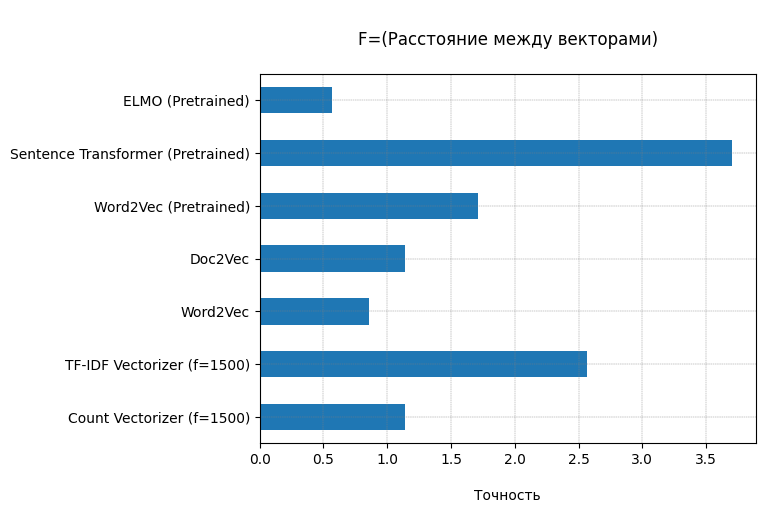

In [25]:
df_compare.plot.barh(title=f"\nF=(Расстояние между векторами)\n")
display(df_compare)
plt.grid(True, color = "grey", linewidth = "0.3", linestyle = "--")
plt.xlabel(f'\nТочность\n')
plt.legend().remove()

In [21]:
# Semantic Search from SBERT: https://sbert.net/examples/applications/semantic-search/README.html

df_sematic_search_compare = {}
for vectorizer in [runCountVectorizer, runTfidfVectorizer, runWord2VecVectorizer, runDoc2VecVectorizer, runWord2VecPretrainedVectorizer, runSentenceTransformerVectorizer, runElmoVectorizer]:
    name, descriptions_vectors, queries_vectors = vectorizer(df_books['clean_description'].values, df_queries['clean_query'].values)

    found = 0
    results = util.semantic_search(util.normalize_embeddings(torch.tensor(queries_vectors.astype(np.float32))),
                                   util.normalize_embeddings(torch.tensor(descriptions_vectors.astype(np.float32))),
                                   top_k=TOP_K)
    print(f"{name}:")
    print(f"  shapes: {descriptions_vectors.shape} x {queries_vectors.shape}")
    
    for index, cur_result in enumerate(results):
        pred = [(df_books.iloc[cur_result[i]['corpus_id']]['book_id'], cur_result[i]['score']) for i in range(len(cur_result))]
        true = df_books[df_books['book_id'] == df_queries.iloc[index]['book_id']]['book_id'].values[0]
        if true in [item[0] for item in pred]:
            found += 1
            
    print(f"  found: {found}\n  total: {len(queries_vectors)}\n  acc: {found/len(queries_vectors)}\n")
    df_sematic_search_compare[name] = found / len(queries_vectors) * 100

df_sematic_search_compare = pd.DataFrame(df_sematic_search_compare).transpose()

Count Vectorizer (f=1500):
  shapes: (86287, 1500) x (351, 1500)
  found: 4
  total: 351
  acc: 0.011396011396011397

TF-IDF Vectorizer (f=1500):
  shapes: (86287, 1500) x (351, 1500)
  found: 9
  total: 351
  acc: 0.02564102564102564



2024-05-17 19:45:48,949 : INFO : collecting all words and their counts
2024-05-17 19:45:48,950 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-05-17 19:45:49,003 : INFO : PROGRESS: at sentence #10000, processed 452199 words, keeping 36783 word types
2024-05-17 19:45:49,044 : INFO : PROGRESS: at sentence #20000, processed 908776 words, keeping 54015 word types
2024-05-17 19:45:49,084 : INFO : PROGRESS: at sentence #30000, processed 1361989 words, keeping 67095 word types
2024-05-17 19:45:49,125 : INFO : PROGRESS: at sentence #40000, processed 1816373 words, keeping 76905 word types
2024-05-17 19:45:49,167 : INFO : PROGRESS: at sentence #50000, processed 2269573 words, keeping 86439 word types
2024-05-17 19:45:49,211 : INFO : PROGRESS: at sentence #60000, processed 2725890 words, keeping 95040 word types
2024-05-17 19:45:49,253 : INFO : PROGRESS: at sentence #70000, processed 3181937 words, keeping 102480 word types
2024-05-17 19:45:49,295 : INFO : PROGRES

Word2Vec:
  shapes: (86287, 100) x (351, 100)
  found: 3
  total: 351
  acc: 0.008547008547008548



2024-05-17 20:00:36,645 : INFO : collecting all words and their counts
2024-05-17 20:00:36,646 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2024-05-17 20:00:36,715 : INFO : PROGRESS: at example #10000, processed 452199 words (6601652 words/s), 36783 word types, 10000 tags
2024-05-17 20:00:36,778 : INFO : PROGRESS: at example #20000, processed 908776 words (7281326 words/s), 54015 word types, 20000 tags
2024-05-17 20:00:36,833 : INFO : PROGRESS: at example #30000, processed 1361989 words (8346445 words/s), 67095 word types, 30000 tags
2024-05-17 20:00:36,889 : INFO : PROGRESS: at example #40000, processed 1816373 words (8267937 words/s), 76905 word types, 40000 tags
2024-05-17 20:00:36,945 : INFO : PROGRESS: at example #50000, processed 2269573 words (8127550 words/s), 86439 word types, 50000 tags
2024-05-17 20:00:37,002 : INFO : PROGRESS: at example #60000, processed 2725890 words (8153293 words/s), 95040 word types, 60000 tags
2024-05-17 20:00:

Doc2Vec:
  shapes: (86287, 100) x (351, 100)
  found: 5
  total: 351
  acc: 0.014245014245014245

Word2Vec (Pretrained):
  shapes: (86287, 300) x (351, 300)
  found: 6
  total: 351
  acc: 0.017094017094017096



2024-05-17 20:33:14,898 : INFO : Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2024-05-17 20:33:17,275 : INFO : Use pytorch device_name: cuda
Batches: 100%|██████████| 11/11 [00:00<00:00, 70.24it/s]


Sentence Transformer (Pretrained):
  shapes: (86287, 384) x (351, 384)
  found: 13
  total: 351
  acc: 0.037037037037037035



2024-05-17 20:48:58,445 : INFO : Loading model from ./elmo...
2024-05-17 20:48:58,446 : INFO : We will cache the vocabulary of 100 tokens.
2024-05-17 20:49:02.305817: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 20:49:02.306164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 20:49:02.306187: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 20:49:02.307605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0

ELMO (Pretrained):
  shapes: (86287, 1024) x (351, 1024)
  found: 2
  total: 351
  acc: 0.005698005698005698



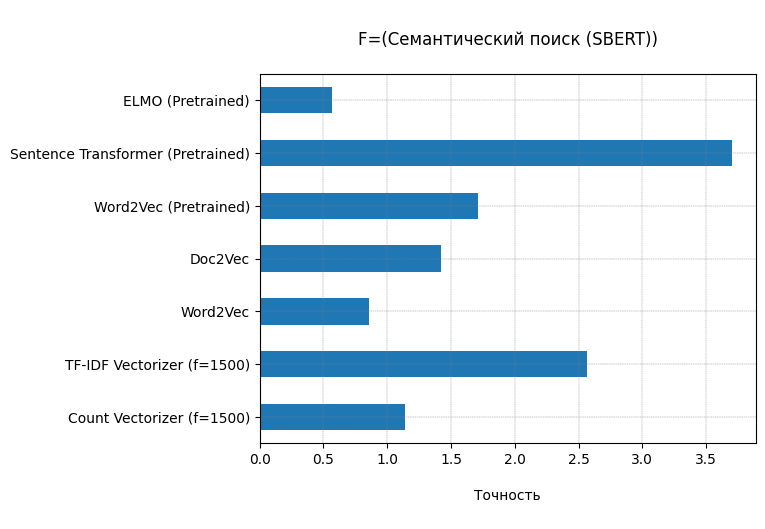

In [22]:
df_sematic_search_compare.plot.barh(title="\nF=(Семантический поиск (SBERT))\n")
plt.grid(True, color = "grey", linewidth = "0.3", linestyle = "--")
plt.xlabel('\nТочность\n')
plt.legend().remove()

# Нейронная сеть

In [57]:
# Подготовка датасета (комбинации запросов и описаний)
true_data = df_queries[['book_id', 'clean_query']].copy()
true_data['clean_description'] = true_data['book_id'].map(lambda x: df_books.loc[df_books['book_id'] == x]['clean_description'].values[0])
true_data['result'] = [1.0 for _ in range(len(true_data))]

# Добавим случайных данных
random_descriptions = df_books['clean_description'].sample(len(true_data) * 10, replace=True).reset_index(drop=True)
random_queries = df_queries['clean_query'].sample(len(true_data) * 10, replace=True).reset_index(drop=True)
random_data = random_descriptions.to_frame().join(random_queries)
random_data['result'] = [0.0 for _ in range(len(random_data))]

data = pd.concat([true_data, random_data])
data = data.sample(frac=1)
display(data['result'].value_counts())
display(data)

result
0.0    3510
1.0     351
Name: count, dtype: int64

,book_id,clean_query,clean_description,result
1551,NaN,think book Judy Blume search Google Books come...,warm sparklingly funny novel family friend fit...,0.0
2012,NaN,remember grab middle school library girl live ...,Nell typical great grandmother course picture ...,0.0
295,1468496.0,connect young kid maybe power strong theirs ho...,Paul recur nightmare small boy awful danger le...,1.0
30,NaN,remember coin fountain emphasize fact run muse...,Benjamin dream build castle father dream write...,0.0
1892,NaN,hello appreciate read middle school maybe earl...,Rachel Kirsty help Dance Fairies groove Dance ...,0.0
...,...,...,...,...
3285,NaN,read book remember somewhat purple color wrong...,charm tender loving story small cat find lose ...,0.0
2940,NaN,girl live boat near dock allow water slip wate...,Little Bear question concern Santa fall asleep...,0.0
186,1309771.0,look book girl live dad sister mom die house f...,Cara Segal bear worrier figure worry work like...,1.0
889,NaN,read book forget title genre fantasy think maj...,Beep beep beep tired machine busy day building...,0.0


Model: "model_62"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_125 (InputLayer)      [(None, 1000)]               0         []                            
                                                                                                  
 input_126 (InputLayer)      [(None, 1000)]               0         []                            
                                                                                                  
 concatenate_62 (Concatenat  (None, 2000)                 0         ['input_125[0][0]',           
 e)                                                                  'input_126[0][0]']           
                                                                                                  
 dense_248 (Dense)           (None, 512)                  1024512   ['concatenate_62[0][0]'

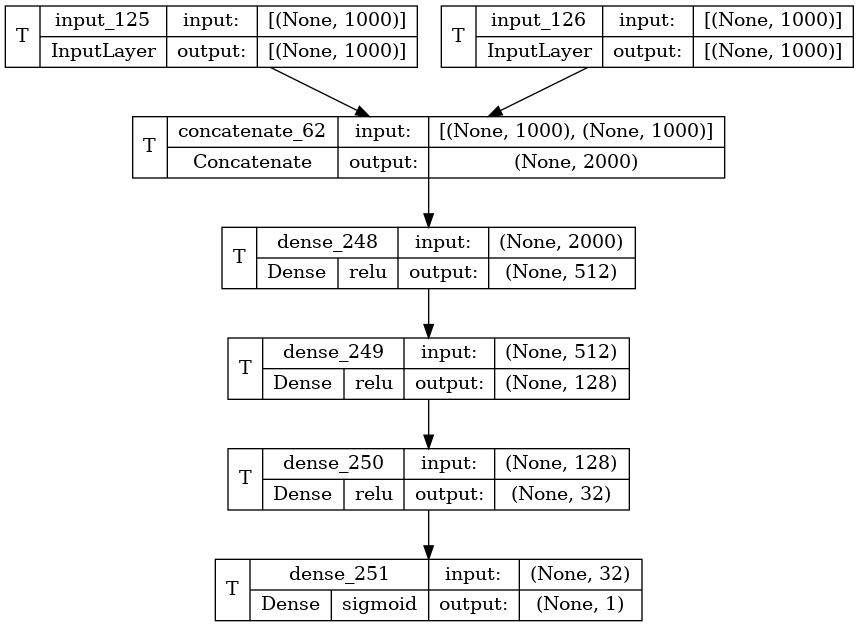

In [247]:
def create_model(input_shape):
    book_input = Input((input_shape,))
    query_input = Input((input_shape,))
    concat_layer = Concatenate()([book_input, query_input])
    dense = Dense(512, activation="relu")(concat_layer)
    dense = Dense(128, activation="relu")(dense)
    dense = Dense(32, activation="relu")(dense)
    output_value = Dense(1, activation="sigmoid")(dense)

    model = Model(inputs=[book_input, query_input], outputs=output_value)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(1000)
model.summary()
plot_model(model, show_shapes=True, show_layer_activations=True, show_trainable=True)

In [245]:
nn_compare = {}
for vectorizer in [runCountVectorizer, runTfidfVectorizer, runWord2VecVectorizer, runDoc2VecVectorizer, runWord2VecPretrainedVectorizer, runSentenceTransformerVectorizer, runElmoVectorizer]:
    name, descriptions_vectors, queries_vectors = vectorizer(data['clean_description'].values, data['clean_query'].values)
    descriptions_vectors = tensorflow.convert_to_tensor(descriptions_vectors.astype(np.float32))
    queries_vectors = tensorflow.convert_to_tensor(queries_vectors.astype(np.float32))
    results = tensorflow.convert_to_tensor(data['result'].values.astype(np.float32))

    print(f"{name}:")
    model = create_model(descriptions_vectors.shape[1])
    history = model.fit([descriptions_vectors, queries_vectors], results, batch_size=32, epochs=20, verbose=1, validation_split=0.1, shuffle=True)
    nn_compare[name] = {'train_accuracy': history.history['accuracy'], 'train_loss': history.history['loss'], 'val_accuracy': history.history['val_accuracy'], 'val_loss': history.history['val_loss']}
    del model


Count Vectorizer (f=1500):
Epoch 1/20
109/109 [==============================] - 1s 7ms/step - loss: 0.3535 - accuracy: 0.9067 - val_loss: 0.3268 - val_accuracy: 0.9199
Epoch 2/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2368 - accuracy: 0.9088 - val_loss: 0.3795 - val_accuracy: 0.9121
Epoch 3/20
109/109 [==============================] - 0s 4ms/step - loss: 0.1489 - accuracy: 0.9444 - val_loss: 0.6403 - val_accuracy: 0.8501
Epoch 4/20
109/109 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9715 - val_loss: 0.9386 - val_accuracy: 0.8992
Epoch 5/20
109/109 [==============================] - 0s 4ms/step - loss: 0.0413 - accuracy: 0.9868 - val_loss: 0.9628 - val_accuracy: 0.8760
Epoch 6/20
109/109 [==============================] - 0s 4ms/step - loss: 0.0263 - accuracy: 0.9917 - val_loss: 1.0195 - val_accuracy: 0.8656
Epoch 7/20
109/109 [==============================] - 0s 4ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 1.2704 - 

2024-05-18 02:24:12,127 : INFO : collecting all words and their counts
2024-05-18 02:24:12,127 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-05-18 02:24:12,141 : INFO : collected 21738 word types from a corpus of 175813 raw words and 3861 sentences
2024-05-18 02:24:12,141 : INFO : Creating a fresh vocabulary
2024-05-18 02:24:12,151 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 5265 unique words (24.22% of original 21738, drops 16473)', 'datetime': '2024-05-18T02:24:12.151390', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
2024-05-18 02:24:12,151 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 149097 word corpus (84.80% of original 175813, drops 26716)', 'datetime': '2024-05-18T02:24:12.151869', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [G

Word2Vec:
Epoch 1/20
109/109 [==============================] - 1s 4ms/step - loss: 0.3489 - accuracy: 0.9004 - val_loss: 0.2787 - val_accuracy: 0.9199
Epoch 2/20
109/109 [==============================] - 0s 4ms/step - loss: 0.3077 - accuracy: 0.9079 - val_loss: 0.2824 - val_accuracy: 0.9199
Epoch 3/20
109/109 [==============================] - 0s 4ms/step - loss: 0.3043 - accuracy: 0.9079 - val_loss: 0.2896 - val_accuracy: 0.9199
Epoch 4/20
109/109 [==============================] - 0s 4ms/step - loss: 0.3040 - accuracy: 0.9079 - val_loss: 0.2800 - val_accuracy: 0.9199
Epoch 5/20
109/109 [==============================] - 0s 4ms/step - loss: 0.3033 - accuracy: 0.9079 - val_loss: 0.2817 - val_accuracy: 0.9199
Epoch 6/20
109/109 [==============================] - 0s 4ms/step - loss: 0.3034 - accuracy: 0.9079 - val_loss: 0.2827 - val_accuracy: 0.9199
Epoch 7/20
109/109 [==============================] - 0s 4ms/step - loss: 0.3004 - accuracy: 0.9079 - val_loss: 0.2755 - val_accuracy: 0.9

2024-05-18 02:24:22,657 : INFO : collecting all words and their counts
2024-05-18 02:24:22,657 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2024-05-18 02:24:22,684 : INFO : collected 21738 word types and 3861 unique tags from a corpus of 3861 examples and 175813 words
2024-05-18 02:24:22,684 : INFO : Creating a fresh vocabulary
2024-05-18 02:24:22,693 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 5265 unique words (24.22% of original 21738, drops 16473)', 'datetime': '2024-05-18T02:24:22.693761', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
2024-05-18 02:24:22,694 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 149097 word corpus (84.80% of original 175813, drops 26716)', 'datetime': '2024-05-18T02:24:22.694228', 'gensim': '4.3.2', 'python': '3.10.12 (main, 

Doc2Vec:
Epoch 1/20
109/109 [==============================] - 1s 5ms/step - loss: 0.3358 - accuracy: 0.9016 - val_loss: 0.2845 - val_accuracy: 0.9199
Epoch 2/20
109/109 [==============================] - 0s 5ms/step - loss: 0.2856 - accuracy: 0.9079 - val_loss: 0.2843 - val_accuracy: 0.9199
Epoch 3/20
109/109 [==============================] - 1s 5ms/step - loss: 0.2823 - accuracy: 0.9079 - val_loss: 0.2811 - val_accuracy: 0.9199
Epoch 4/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2764 - accuracy: 0.9079 - val_loss: 0.2683 - val_accuracy: 0.9199
Epoch 5/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2726 - accuracy: 0.9079 - val_loss: 0.2758 - val_accuracy: 0.9199
Epoch 6/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2768 - accuracy: 0.9079 - val_loss: 0.2743 - val_accuracy: 0.9199
Epoch 7/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2699 - accuracy: 0.9076 - val_loss: 0.2797 - val_accuracy: 0.91

2024-05-18 02:24:50,988 : INFO : Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2024-05-18 02:24:52,577 : INFO : Use pytorch device_name: cuda
Batches: 100%|██████████| 121/121 [00:01<00:00, 106.62it/s]


Sentence Transformer (Pretrained):
Epoch 1/20
109/109 [==============================] - 1s 5ms/step - loss: 0.3128 - accuracy: 0.9047 - val_loss: 0.2822 - val_accuracy: 0.9199
Epoch 2/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2776 - accuracy: 0.9079 - val_loss: 0.2730 - val_accuracy: 0.9199
Epoch 3/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2550 - accuracy: 0.9079 - val_loss: 0.2720 - val_accuracy: 0.9199
Epoch 4/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2192 - accuracy: 0.9116 - val_loss: 0.3047 - val_accuracy: 0.9147
Epoch 5/20
109/109 [==============================] - 0s 4ms/step - loss: 0.1550 - accuracy: 0.9378 - val_loss: 0.3682 - val_accuracy: 0.9121
Epoch 6/20
109/109 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9660 - val_loss: 0.4190 - val_accuracy: 0.8992
Epoch 7/20
109/109 [==============================] - 0s 4ms/step - loss: 0.0332 - accuracy: 0.9885 - val_loss: 0

2024-05-18 02:25:05,056 : INFO : Loading model from ./elmo...
2024-05-18 02:25:05,056 : INFO : We will cache the vocabulary of 100 tokens.
2024-05-18 02:25:06.316765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 02:25:06.316853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 02:25:06.316874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 02:25:06.317290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0

ELMO (Pretrained):
Epoch 1/20
109/109 [==============================] - 1s 5ms/step - loss: 0.3132 - accuracy: 0.9050 - val_loss: 0.2684 - val_accuracy: 0.9199
Epoch 2/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2856 - accuracy: 0.9079 - val_loss: 0.2688 - val_accuracy: 0.9199
Epoch 3/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2790 - accuracy: 0.9079 - val_loss: 0.2687 - val_accuracy: 0.9199
Epoch 4/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2702 - accuracy: 0.9085 - val_loss: 0.2696 - val_accuracy: 0.9199
Epoch 5/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2641 - accuracy: 0.9082 - val_loss: 0.2731 - val_accuracy: 0.9199
Epoch 6/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2550 - accuracy: 0.9079 - val_loss: 0.2746 - val_accuracy: 0.9199
Epoch 7/20
109/109 [==============================] - 0s 4ms/step - loss: 0.2553 - accuracy: 0.9073 - val_loss: 0.3083 - val_accu

In [230]:
df_nn_compare = pd.DataFrame(nn_compare)
df_nn_compare = df_nn_compare.transpose()
df_nn_compare

,train_accuracy,train_loss,val_accuracy,val_loss
Count Vectorizer (f=1500),"[0.9004030227661133, 0.9078871607780457, 0.933...","[0.3442489504814148, 0.23477834463119507, 0.14...","[0.91989666223526, 0.91989666223526, 0.8940568...","[0.314953088760376, 0.3809811770915985, 0.6353..."
TF-IDF Vectorizer (f=1500),"[0.8992515802383423, 0.9078871607780457, 0.916...","[0.34348246455192566, 0.22892843186855316, 0.1...","[0.91989666223526, 0.91989666223526, 0.8837209...","[0.29300621151924133, 0.366392582654953, 0.500..."
Word2Vec,"[0.9015544056892395, 0.9078871607780457, 0.907...","[0.3398245871067047, 0.30766162276268005, 0.30...","[0.91989666223526, 0.91989666223526, 0.9198966...","[0.27937328815460205, 0.2819448709487915, 0.28..."
Doc2Vec,"[0.9018422365188599, 0.9078871607780457, 0.907...","[0.32857415080070496, 0.2884730100631714, 0.28...","[0.91989666223526, 0.91989666223526, 0.9198966...","[0.28075048327445984, 0.2724841833114624, 0.27..."
Word2Vec (Pretrained),"[0.9067357778549194, 0.9078871607780457, 0.907...","[0.3234628438949585, 0.28613001108169556, 0.27...","[0.91989666223526, 0.91989666223526, 0.9198966...","[0.272929310798645, 0.26566579937934875, 0.273..."
Sentence Transformer (Pretrained),"[0.9061600565910339, 0.9078871607780457, 0.907...","[0.31975826621055603, 0.2798594832420349, 0.25...","[0.91989666223526, 0.91989666223526, 0.9198966...","[0.27095723152160645, 0.2766050398349762, 0.29..."
ELMO (Pretrained),"[0.9032815098762512, 0.9078871607780457, 0.907...","[0.31809064745903015, 0.2842879891395569, 0.28...","[0.91989666223526, 0.91989666223526, 0.9198966...","[0.26938363909721375, 0.2730848491191864, 0.26..."


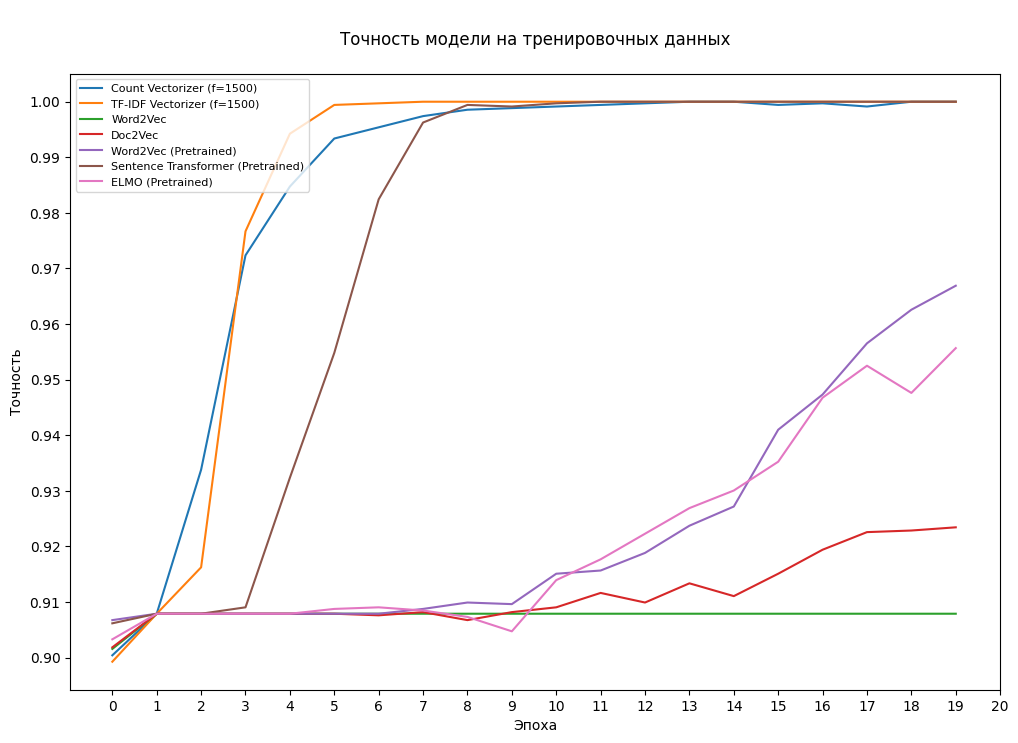

In [231]:
plt.figure(figsize=(12, 8))
for vectorizer in df_nn_compare.index.to_list():
    plt.plot(df_nn_compare['train_accuracy'][vectorizer])
plt.title('\nТочность модели на тренировочных данных\n')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.yticks(np.arange(0.9, 1.0001, 0.01))
plt.xticks(np.arange(0, 21, 1))
plt.legend(df_nn_compare.index.to_list(), loc='upper left', prop={'size': 8})

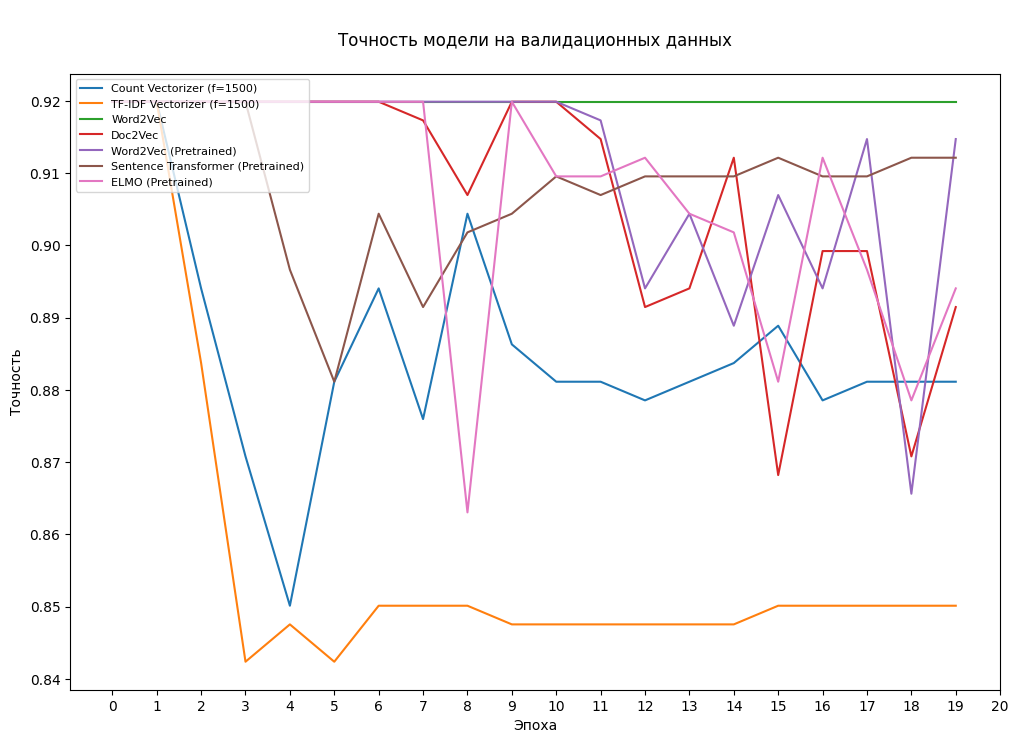

In [232]:
plt.figure(figsize=(12, 8))
for vectorizer in df_nn_compare.index.to_list():
    plt.plot(df_nn_compare['val_accuracy'][vectorizer])
plt.title('\nТочность модели на валидационных данных\n')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.xticks(np.arange(0, 21, 1))
plt.legend(df_nn_compare.index.to_list(), loc='upper left', prop={'size': 8})

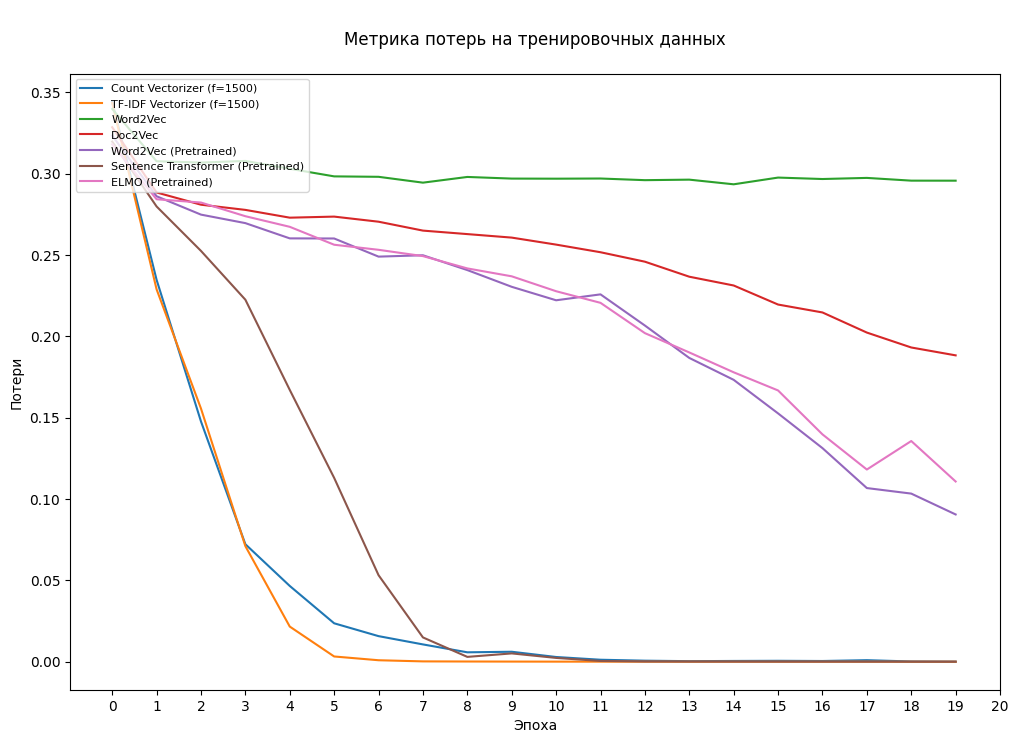

In [248]:
plt.figure(figsize=(12, 8))
for vectorizer in df_nn_compare.index.to_list():
    plt.plot(df_nn_compare['train_loss'][vectorizer])
plt.title('\nМетрика потерь на тренировочных данных\n')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.xticks(np.arange(0, 21, 1))
plt.legend(df_nn_compare.index.to_list(), loc='upper left', prop={'size': 8})

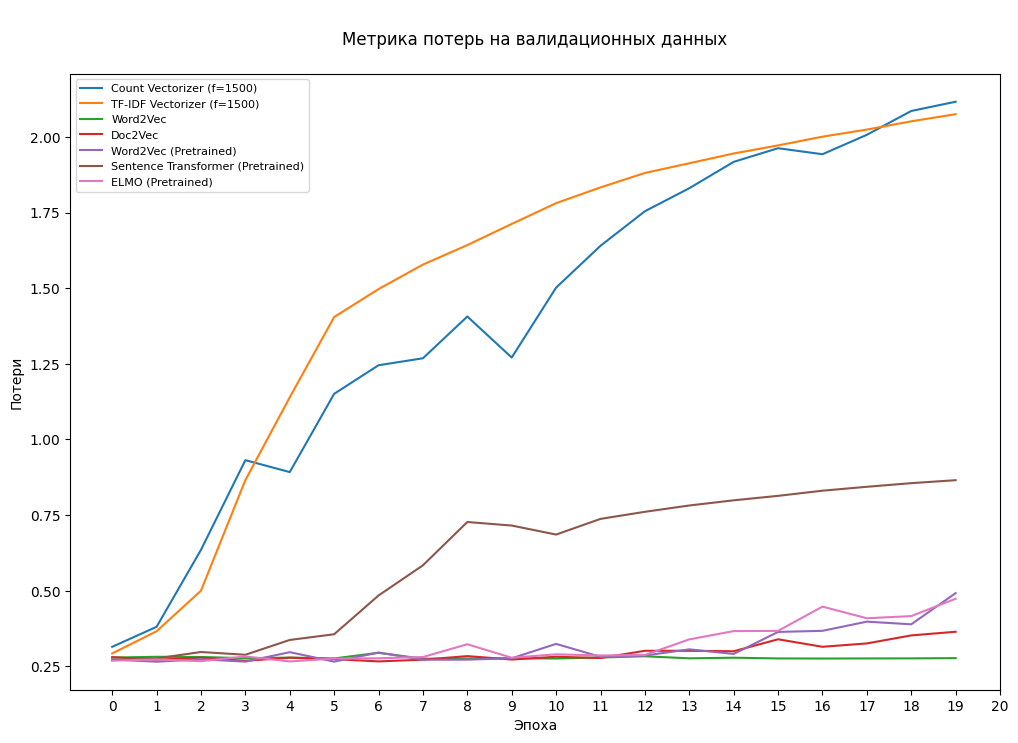

In [249]:
plt.figure(figsize=(12, 8))
for vectorizer in df_nn_compare.index.to_list():
    plt.plot(df_nn_compare['val_loss'][vectorizer])
plt.title('\nМетрика потерь на валидационных данных\n')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.xticks(np.arange(0, 21, 1))
plt.legend(df_nn_compare.index.to_list(), loc='upper left', prop={'size': 8})